In [1]:
pip install sounddevice numpy scipy pyaudio librosa sklearn

  Using cached sklearn-0.0.post7.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
     

In [1]:
import pyaudio
import wave
import librosa
import scipy.io.wavfile as wavfile
import numpy as np

# Initialize audio settings
chunk = 1024
format = pyaudio.paInt16
channels = 1
rate = 44100

# Initialize the PyAudio object
p = pyaudio.PyAudio()

# List of questions
questions = ["What is your name?", "Where are you from?", "Tell me about your hobbies."]

recorded_answers = []

# Ask questions and record answers
for i, question in enumerate(questions):
    print(question)
    
    # Record answer
    stream = p.open(format=format, channels=channels, rate=rate, input=True, frames_per_buffer=chunk)
    print("Recording...")
    frames = []
    for _ in range(int(rate / chunk) * 5):  # Record for 5 seconds
        data = stream.read(chunk)
        frames.append(data)
    print("Recording finished.")
    
    # Save recorded answer to a file
    filename = f"answer_{i}.wav"
    recorded_answers.append(filename)
    wf = wave.open(filename, 'wb')
    wf.setnchannels(channels)
    wf.setsampwidth(p.get_sample_size(format))
    wf.setframerate(rate)
    wf.writeframes(b''.join(frames))
    wf.close()
    
    stream.stop_stream()
    stream.close()

# Combine recorded answers
combined_audio = np.concatenate([librosa.load(filename, sr=rate)[0] for filename in recorded_answers])

# Generate a single audio waveform
combined_filename = "combined_answers.wav"
wavfile.write(combined_filename, rate, combined_audio)
print("Combined audio wave generated.")

# Close the PyAudio object
p.terminate()

What is your name?
Recording...
Recording finished.
Where are you from?
Recording...
Recording finished.
Tell me about your hobbies.
Recording...
Recording finished.
Combined audio wave generated.


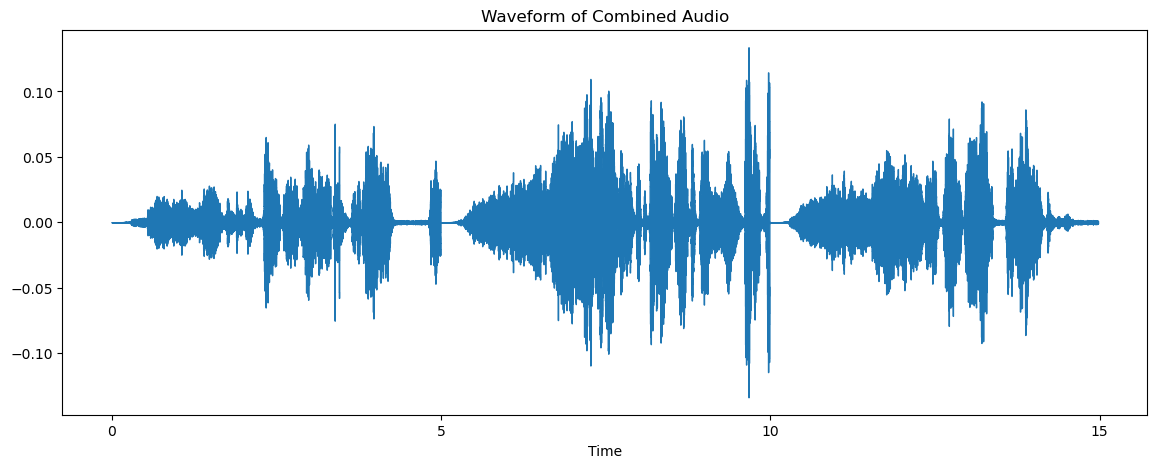

In [2]:
import matplotlib.pyplot as plt
import IPython.display as ipd

filename = 'combined_answers.wav'

# Display waveform plot
plt.figure(figsize=(14, 5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
plt.title("Waveform of Combined Audio")
plt.show()

# Play the audio
ipd.Audio(filename)

44100
[ 0.0000000e+00  0.0000000e+00 -3.0517578e-05 ...  1.2207031e-04
 -1.2207031e-04 -3.9672852e-04]


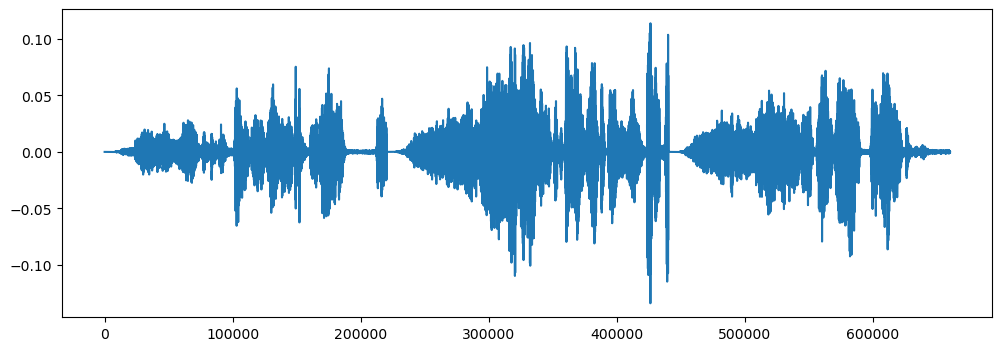

In [3]:
filepath = 'combined_answers.wav'
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(filepath)
print(wave_sample_rate)
print(wave_audio)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

In [ ]:
### apply audio classification algorithm.

In [12]:
import librosa
import numpy as np
import tensorflow as tf
from pydub import AudioSegment

# Load the combined audio waveform
combined_filename = "combined_answers.wav"
combined_audio = AudioSegment.from_wav(combined_filename)

# Convert the combined audio to a NumPy array
combined_audio_array = np.array(combined_audio.get_array_of_samples())

# Sample rate of the audio
sample_rate = combined_audio.frame_rate

# Extract MFCC features
mfccs_features = librosa.feature.mfcc(y=combined_audio_array, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

# Load a pre-trained model from TensorFlow Hub
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(40,)),
    tf.keras.layers.Reshape((40, 1)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Replace num_classes with the number of classes in your task
])

model_path = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5"
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    hub.KerasLayer(model_path)
])

# Load the model's weights
model.load_weights("path_to_pretrained_model_weights.h5")

# Prepare the features for prediction
input_features = mfccs_scaled_features.reshape(1, -1)

# Predict the class using the loaded model
predicted_probs = model.predict(input_features)
predicted_class = np.argmax(predicted_probs)
print("Predicted Class:", predicted_class)


C:\Users\HP\anaconda3\Lib\site-packages\pydub\utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [18]:
def features_extractor(audio, sample_rate):
    # Extract MFCC features
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    # Calculate scaled feature by taking the mean along time axis
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

# Apply feature extraction to the combined audio
mfccs_scaled_features = features_extractor(wave_audio, wave_sample_rate)
print("MFCCs Scaled Features:", mfccs_scaled_features)


MFCCs Scaled Features: [-6.4122076e+02  1.5949493e+02 -2.1781919e+01  8.0701313e+00
  1.8186003e+00  3.3021617e-01  1.7394852e+01 -3.9892063e+00
  6.1343932e+00  5.9616094e+00 -7.8735175e+00  9.8435384e-01
 -8.9089184e+00 -1.2165040e+01 -3.4876800e+00 -5.0990467e+00
  1.4552693e+00  1.1673920e+00 -3.6839571e+00 -2.0835266e+00
 -4.7040219e+00 -2.2017419e+00 -1.5196159e+00 -6.2885222e+00
 -5.2673521e+00 -5.5658731e+00 -4.8552852e+00 -2.0362055e+00
 -3.5417111e+00 -2.7984281e+00  8.6652583e-01  1.6842839e+00
  4.4836435e-03 -1.6096580e-01  9.7326916e-01  3.0932876e-01
  6.5174496e-01  1.2999479e+00  2.4116720e-01  5.8067882e-01]


In [ ]:
import kapre
import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the trained VGGish model from kapre
vggish_model = kapre.time_frequency.VGGish(input_shape=(1, None, 1), include_top=False, weights='audioset')
x = GlobalAveragePooling2D()(vggish_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=vggish_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load weights for the VGGish part
model.load_weights('vggish_weights.h5')  # Replace with the actual path

# Load the combined audio waveform
combined_wave, _ = librosa.load("combined_answers.wav", sr=rate)

# Extract Mel-spectrogram features using kapre's Melspectrogram layer
melspectrogram = kapre.time_frequency.Melspectrogram(n_mels=64)(np.expand_dims(combined_wave, axis=0))
melspectrogram = np.expand_dims(melspectrogram, axis=0)

# Predict using the pre-trained model
combined_prediction = model.predict(melspectrogram)
combined_predicted_label = np.argmax(combined_prediction)

if combined_predicted_label == 1:
    print("Recognized your voice in the combined answer.")
else:
    print("Voice not recognized in the combined answer.")


In [3]:
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.applications import VGGish
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the trained VGGish model
vggish_model = VGGish(include_top=False, weights='audioset', input_shape=(96, 64, 1))
x = GlobalAveragePooling2D()(vggish_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=vggish_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load weights for the VGGish part
model.load_weights('vggish_weights.h5')  # Replace with the actual path

# Load the new input audio waveform
new_wave, _ = librosa.load(new_filename, sr=rate)

# Extract MFCCs from the new input audio
mfccs = librosa.feature.mfcc(y=new_wave, sr=rate, n_mfcc=64)
mfccs = np.expand_dims(mfccs, axis=-1)
mfccs = np.expand_dims(mfccs, axis=0)

# Predict using the pre-trained model
prediction = model.predict(mfccs)
predicted_label = np.argmax(prediction)

if predicted_label == 1:
    print("Recognized your voice in the new input.")
else:
    print("Voice not recognized in the new input.")


TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [ ]:


# Step 1: Load and preprocess audio data
def load_audio(file_path, duration=3, sr=22050):
    audio, _ = librosa.load(file_path, sr=sr, duration=duration)
    return audio

# Step 2: Feature extraction
def extract_mfcc(audio, n_mfcc=13):
    mfccs = librosa.feature.mfcc(audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs

# Step 4: Model selection and training
def build_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Step 6: Generate audio waveform
def record_audio(output_path, duration=3, sr=22050):
    audio = input("Please speak something: ")
    librosa.output.write_wav(output_path, audio, sr=sr)

# Step 7: Real-time prediction
def predict_voice(model, audio_path):
    audio = load_audio(audio_path)
    mfccs = extract_mfcc(audio)
    mfccs = np.expand_dims(mfccs, axis=-1)
    predicted_class = np.argmax(model.predict(np.array([mfccs])))
    return predicted_class

if __name__ == "__main__":
    sr = 22050
    num_classes = 2  # You vs. Others

    # Step 3: Dataset creation (for demonstration purposes)
    your_voice_samples = ["your_voice_sample1.wav", "your_voice_sample2.wav"]
    other_samples = ["other_sample1.wav", "other_sample2.wav"]

    X = []
    y = []

    for file_path in your_voice_samples:
        audio = load_audio(file_path)
        mfccs = extract_mfcc(audio)
        X.append(mfccs)
        y.append(0)  # Your voice class

    for file_path in other_samples:
        audio = load_audio(file_path)
        mfccs = extract_mfcc(audio)
        X.append(mfccs)
        y.append(1)  # Other voice class

    X = np.array(X)
    y = np.array(y)

    input_shape = X[0].shape

    # Step 4: Model training
    model = build_model(input_shape, num_classes)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X, y, epochs=10)

    # Step 6: Generate and predict audio
    recorded_audio_path = "recorded_audio.wav"
    record_audio(recorded_audio_path)
    predicted_class = predict_voice(model, recorded_audio_path)

    if predicted_class == 0:
        print("Recognized your voice.")
    else:
        print("Voice not recognized.")

